# Comparing MAGeT ans SUIT results
## Data: 
    - 1. Cerebellar SUIT segmentation; 
         - SUIT: Left/right 1-X+Dentate+Interposed+Fastigial and Vermis
    - 2. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Left/right 1-X+WhiteMatter(CM)
          maget_df.columns=
          ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM', 
           'R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II', 'R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']
          No vermis in MAGeT as well.
## Cohorts
- The augmented cohort 211: MNI ET/ matched NC (34/177).

## Tasks: GLM for 
- Compare lobule volumes： 

## Covariates
- Age, Sex, intracranial volume (eTIV, cerebellar volume), site.

In [1]:
#reading/merging/selecting data
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
maget_dir = Path("/codes/preproc/maget/results")
cohorts_str = ['ADNI','ET','NC','PPMI']
# preproce of MAGeT resutls
et_maget_read = pd.read_csv(maget_dir/('ET_volumes.csv'), sep=',', header=0, index_col=0)
et_maget_read.index= [x[2:10] for x in et_maget_read.index]
nc_maget_read = pd.read_csv(maget_dir/('NC_volumes.csv'), sep=',', header=0, index_col=0)
nc_maget_read.index= [x[2:10] for x in nc_maget_read.index]
adni_maget_read = pd.read_csv(maget_dir/('ADNI_volumes.csv'), sep=',', header=0, index_col=0)
ppmi_maget_read = pd.read_csv(maget_dir/('PPMI_volumes.csv'), sep=',', header=0, index_col=0)
maget_df = pd.concat([et_maget_read,nc_maget_read,ppmi_maget_read,adni_maget_read])
maget_df.index= [x.replace('-','_') for x in maget_df.index]
maget_df.loc[:,'L_I_IV']  = maget_df.loc[:,'L_I_II']+maget_df.loc[:,'L_III']+maget_df.loc[:,'L_IV']
maget_df.loc[:,'R_I_IV'] = maget_df.loc[:,'R_I_II']+maget_df.loc[:,'R_III']+maget_df.loc[:,'R_IV']

# merge lobule data
matched_data_file  = data_dir/'matched_Des-cere_qced.csv'
data_df = pd.read_csv(matched_data_file , sep=',', header=0, index_col=0);
data_df = data_df.join(maget_df, how='left').copy()

In [2]:
#GLM analysis and non-parametric comparison
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 
                 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 
                 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII',
                 'Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X',
                 'Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 
                 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MAGeT_l_labels = ['L_I_IV',  'L_V', 'L_VI', 'L_Crus_I', 'L_Crus_II', 
                 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X'];  # NO  'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'
MAGeT_r_labels = ['R_I_IV','R_V','R_VI','R_Crus_I','R_Crus_II',
                 'R_VIIB','R_VIIIA','R_VIIIB','R_IX','R_X'];  # NO  'Right_Dentate','Right_Interposed','Right_Fastigial'
length_lubule_list=len(MAGeT_l_labels)

qc_list = ['freesurfer_score', 'suit_score', 'maget_score']
analysis_list = ['age','sex','group', 'cohort','site','eTIV', 'is_adni', 'is_mni', 'is_ppmi', 'male',
                 'SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex',
                 'Cerebellum_White_Matter', 'Cerebellum_Cortex', 'cerebellumVol', 'InfraTentorialVol']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MAGeT_l_labels+MAGeT_r_labels+qc_list;


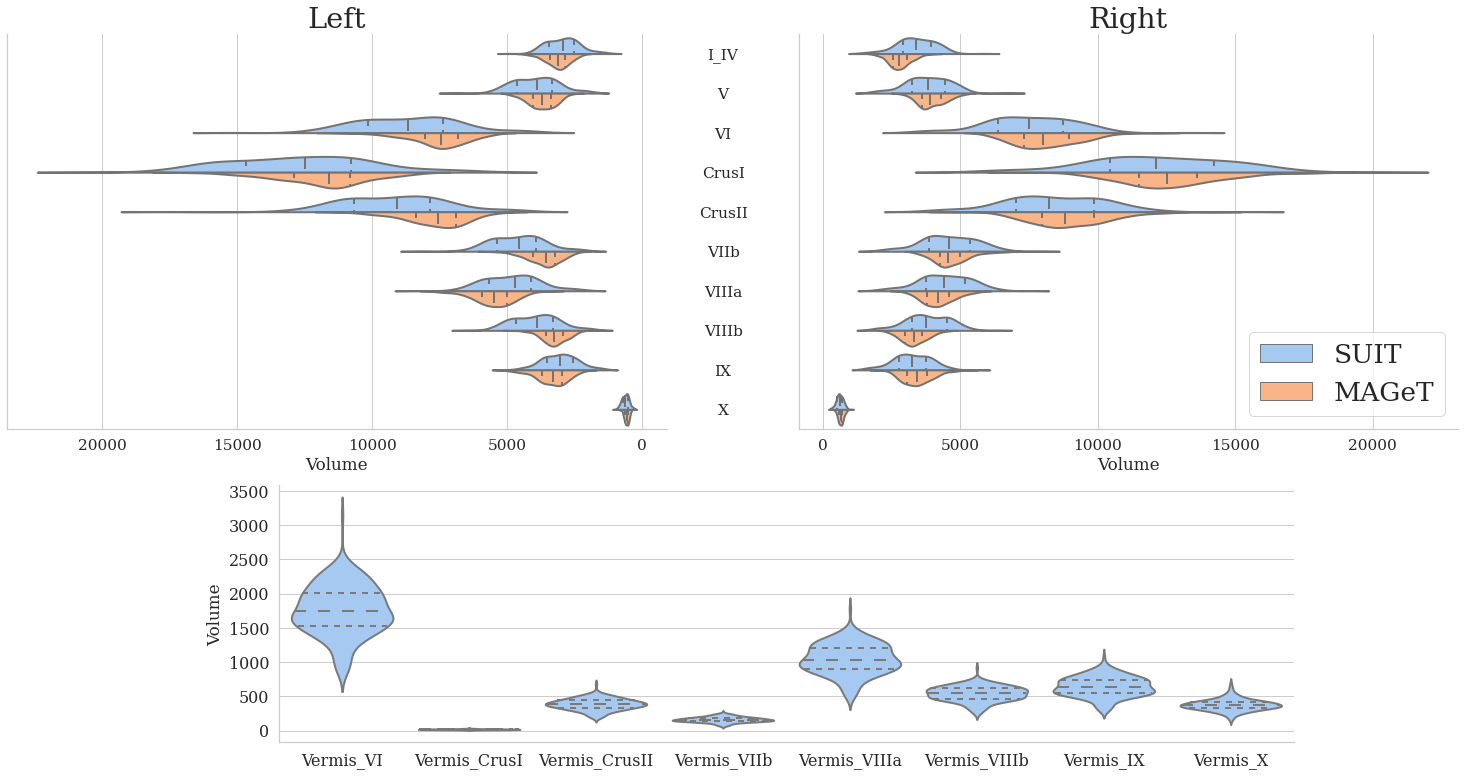

In [106]:
# distribution plot for all the suit and maget
figure_size=(26, 16); 
FONT_SCALE=2.4;

lobule_list = ['I_IV', 'V', 'VI', 'CrusI', 'CrusII', 'VIIb', 'VIIIa', 'VIIIb', 'IX', 'X'];
dis_df=data_df.copy()

def pivot_cere_df(df, col_list, loc_str, pipeline_str):
    # creat melted dataframe (sub,roi,loc,vol,pipeline) from visualization from raw dataframe (sub*ROI)
    df.columns = col_list; 
    df.loc[:,'sub']=df.index;
    df = pd.melt(df, id_vars='sub', value_vars=col_list, var_name='Lobule', value_name='Volume');
    df.loc[:,'Hemisphere']=loc_str; df.loc[:,'Pipeline']=pipeline_str;
    return df.copy()

suit_l_df_ = dis_df.loc[:, SUIT_l_labels[:length_lubule_list]].copy(); 
suit_l_df_ = pivot_cere_df(suit_l_df_, lobule_list, 'Left', 'SUIT')
suit_r_df_ = dis_df.loc[:, SUIT_r_labels[:length_lubule_list]].copy(); 
suit_r_df_ = pivot_cere_df(suit_r_df_, lobule_list, 'Right', 'SUIT')
suit_v_df_ = dis_df.loc[:, SUIT_v_labels].copy(); 
suit_v_df_ = pivot_cere_df(suit_v_df_, SUIT_v_labels, 'Vermis', 'SUIT')

maget_l_df_ = dis_df.loc[:, MAGeT_l_labels].copy(); 
maget_l_df_ = pivot_cere_df(maget_l_df_, lobule_list, 'Left', 'MAGeT')
maget_r_df_ = dis_df.loc[:, MAGeT_r_labels].copy(); 
maget_r_df_ = pivot_cere_df(maget_r_df_, lobule_list, 'Right', 'MAGeT')

lobule_df = pd.concat([suit_l_df_, suit_r_df_, maget_l_df_, maget_r_df_])
#lobule_df['Volume']=np.log(lobule_df['Volume'])

## vis
f1 = plt.figure(figsize=figure_size, facecolor='w', edgecolor='lightgray')
gs = f1.add_gridspec(2, 2)
ax1 = f1.add_subplot(gs[0, 0])
ax2 = f1.add_subplot(gs[0, 1])
ax3 = f1.add_subplot(gs[1, :])

# Fig. a
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.violinplot(data=lobule_df[lobule_df['Hemisphere']=='Left'], x="Volume", y="Lobule", hue="Pipeline",
               split=True, inner="quartile",  scale='count', bw='silverman', orient='h',
               ax=ax1, linewidth=2, saturation=0.9)
ax1.invert_xaxis()
ax1.get_legend().remove()
ax1.get_xaxis().set_visible(True)
ax1.set(yticklabels=[])
ax1.set(ylabel=None)
ax1.set_title('Left',fontsize='medium')
pos1 = ax1.get_position()
ax1.set_position([pos1.x0, pos1.y0,  pos1.width, pos1.height])

# Fig. b
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.despine();
sns.violinplot(data=lobule_df[lobule_df['Hemisphere']=='Right'], x="Volume", y="Lobule", hue="Pipeline",
               split=True, inner="quartile",  scale='count', bw='silverman', orient='h', 
               ax=ax2, linewidth=2, saturation=0.9)
ax2.get_yaxis().set_visible(True)
ax2.get_xaxis().set_visible(True)
ax2.set_title('Right',fontsize='medium')
ax2.set(ylabel=None)
ax2.legend(loc='lower right')
# ceter y ticklabels
for tick in ax2.yaxis.get_majorticklabels():
    tick.set_horizontalalignment('center')
    pos_tmp=tick.get_position()
    tick.set_position((pos_tmp[0]-0.1,pos_tmp[1]))
    
# Fig. c
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE-1)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.despine();
sns.violinplot(data=suit_v_df_, y="Volume", x="Lobule",
               inner="quartile",  scale='width', bw='silverman', orient='v', 
               ax=ax3, linewidth=2, color=sns.color_palette("pastel")[0], saturation=0.9)
ax3.get_yaxis().set_visible(True)
ax3.set(xlabel=None)
ax3.tick_params(axis='both', which='major', labelsize=16)
pos3 = ax3.get_position()
ax3.set_position([pos3.x0+0.145, pos3.y0+0.14,  pos3.width*0.7, pos3.height*0.65])

f1.savefig("Fig2-lobule_distr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

TypeError: 'Figure' object is not callable

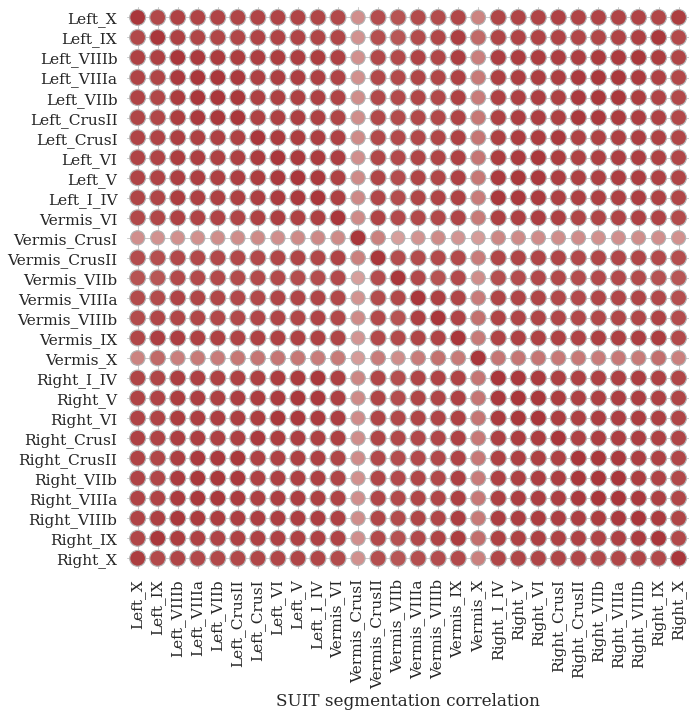

In [162]:
# correlation plot for all the suit and maget results
# distribution plot for all the suit and maget
figure_size=(20, 20); 
FONT_SCALE=1.4;

lobule_list = ['I_IV', 'V', 'VI', 'CrusI', 'CrusII', 'VIIb', 'VIIIa', 'VIIIb', 'IX', 'X'];
SUIT_l_labels_= SUIT_l_labels[:length_lubule_list]; SUIT_l_labels_.reverse()
suit_labels=SUIT_l_labels_+SUIT_r_labels[:length_lubule_list];
MAGeT_l_labels_= MAGeT_l_labels; MAGeT_l_labels_.reverse();
vis_df=data_df.copy()
#vis_df=vis_df.loc[:,SUIT_l_labels[:length_lubule_list]+SUIT_v_labels+SUIT_r_labels[:length_lubule_list]+MAGeT_l_labels+MAGeT_r_labels];
suit_df_ = vis_df.loc[:,SUIT_l_labels_+SUIT_v_labels+SUIT_r_labels[:length_lubule_list]].copy()
maget_df_ = vis_df.loc[:,MAGeT_l_labels_+MAGeT_r_labels].copy()

suit_corr_df =suit_df_.corr(); suit_corr_long_df = suit_corr_df.stack().reset_index(name="Correlation")
maget_corr_df=maget_df_.corr(); 
maget_corr_df.index=suit_labels; maget_corr_df.columns=suit_labels;
maget_corr_long_df = maget_corr_df.stack().reset_index(name="Correlation")

## vis
# Fig.2a
#f2 = plt.figure(figsize=figure_size, facecolor='w', edgecolor='lightgray')
#ax3 = f1.add_subplot(gs[1, :])
sns.set_theme(style="whitegrid", palette="pastel", font_scale=FONT_SCALE)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

# Fig. a
g = sns.relplot(
    data=suit_corr_long_df,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8), legend=False
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
g.set_xlabels('SUIT segmentation correlation')
#g._legend.remove()
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
#g.fig(figsize=figure_size)

g = sns.relplot(
    data=maget_corr_long_df,
    x="level_0", y="level_1", hue="Correlation", size="Correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-0.2, 0.8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
g.set_xlabels('MAGeT segmentation correlation')
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")
#g.fig(figsize=figure_size)
# Fig2.b
# Heatmap of correlation matrix between SUIT and MAGeT measures (Augmented NC)


#f2.savefig("Fig2-lobule_distr.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1)

In [161]:
g.fig.set_figure.

[<AxesSubplot:xlabel='MAGeT segmentation correlation'>]

In [131]:
print(MAGeT_l_labels_)

None


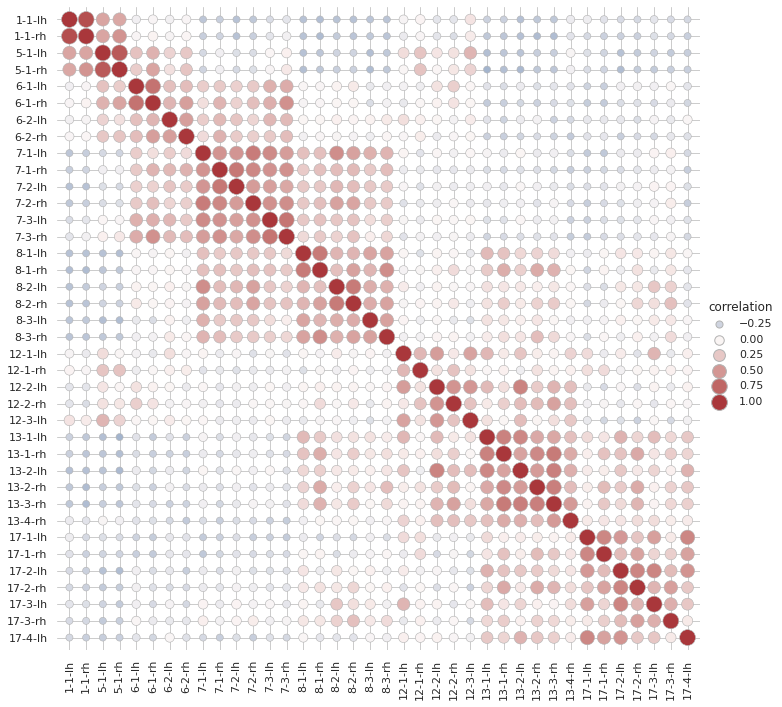

In [110]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the brain networks dataset, select subset, and collapse the multi-index
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

used_networks = [1, 5, 6, 7, 8, 12, 13, 17]
used_columns = (df.columns
                  .get_level_values("network")
                  .astype(int)
                  .isin(used_networks))
df = df.loc[:, used_columns]

df.columns = df.columns.map("-".join)

# Compute a correlation matrix and convert to long-form
corr_mat = df.corr().stack().reset_index(name="correlation")

# Draw each cell as a scatter point with varying size and color
g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [133]:
corr_mat

,level_0,level_1,correlation
0,1-1-lh,1-1-lh,1.000000
1,1-1-lh,1-1-rh,0.881516
2,1-1-lh,5-1-lh,0.431619
3,1-1-lh,5-1-rh,0.418708
4,1-1-lh,6-1-lh,-0.084634
...,...,...,...
1439,17-4-lh,17-2-lh,0.517481
1440,17-4-lh,17-2-rh,0.256544
1441,17-4-lh,17-3-lh,0.264381
1442,17-4-lh,17-3-rh,0.090302


In [68]:

C_MAP='coolwarm'; TH=0.4

# select data
vis_df=data_df.copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:end_lubule_list]+SUIT_v_labels+SUIT_r_labels[:end_lubule_list]+MAGeT_l_labels+MAGeT_r_labels]
# data proc
corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')

# Draw a heatmap with the numeric values in each cell

sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (Augmented cohort)', fontsize=28)
line_pos=[end_lubule_list,end_lubule_list+len(SUIT_v_labels),end_lubule_list*2+len(SUIT_v_labels),end_lubule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
#f1.savefig("Augmented-Cohort_SUIT-MAGeT_comp.jpg")
display(corr_)

<AxesSubplot:title={'center':'Hemisphere = Left'}, xlabel='Vol', ylabel='Lobule'>

,Left_I_IV,Left_V,Left_VI,Left_CrusI,Left_CrusII,Left_VIIb,Left_VIIIa,Left_VIIIb,Left_IX,Left_X,...,R_I_IV,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X
Left_I_IV,1.000000,0.982452,0.970506,0.953836,0.947013,0.948965,0.952291,0.961004,0.925529,0.927165,...,0.526292,0.448895,0.216491,0.419046,0.375707,0.299882,0.257166,0.365614,0.367536,-0.025335
Left_V,0.982452,1.000000,0.983181,0.961845,0.954851,0.951845,0.953389,0.960080,0.930211,0.933815,...,0.467451,0.465564,0.230003,0.415937,0.381757,0.316459,0.246257,0.376609,0.365613,0.002627
Left_VI,0.970506,0.983181,1.000000,0.969993,0.949950,0.951935,0.955183,0.962444,0.934460,0.934712,...,0.424740,0.410979,0.229750,0.424997,0.361650,0.310761,0.238754,0.367949,0.363728,0.000137
Left_CrusI,0.953836,0.961845,0.969993,1.000000,0.944988,0.948843,0.952873,0.955616,0.930424,0.937021,...,0.417422,0.390458,0.204797,0.493076,0.336786,0.296900,0.234791,0.356934,0.372307,0.000314
Left_CrusII,0.947013,0.954851,0.949950,0.944988,1.000000,0.986585,0.980025,0.961139,0.918947,0.927759,...,0.419338,0.382458,0.201495,0.409052,0.462847,0.399737,0.311845,0.375674,0.402610,0.018671
Left_VIIb,0.948965,0.951845,0.951935,0.948843,0.986585,1.000000,0.995063,0.972644,0.914358,0.932507,...,0.438363,0.383232,0.208713,0.423254,0.451157,0.405765,0.323556,0.379908,0.396207,0.007986
Left_VIIIa,0.952291,0.953389,0.955183,0.952873,0.980025,0.995063,1.000000,0.980083,0.923356,0.934056,...,0.446430,0.393615,0.205350,0.421699,0.440577,0.388805,0.326636,0.384302,0.401925,0.000289
Left_VIIIb,0.961004,0.960080,0.962444,0.955616,0.961139,0.972644,0.980083,1.000000,0.949083,0.939224,...,0.471364,0.429436,0.182492,0.416028,0.397531,0.340958,0.288700,0.413778,0.440860,-0.034535
Left_IX,0.925529,0.930211,0.934460,0.930424,0.918947,0.914358,0.923356,0.949083,1.000000,0.908027,...,0.429610,0.425328,0.184519,0.425915,0.388044,0.304610,0.249243,0.397439,0.558130,0.011445
Left_X,0.927165,0.933815,0.934712,0.937021,0.927759,0.932507,0.934056,0.939224,0.908027,1.000000,...,0.432483,0.388536,0.198483,0.412579,0.341025,0.282504,0.210270,0.316232,0.371119,0.029298


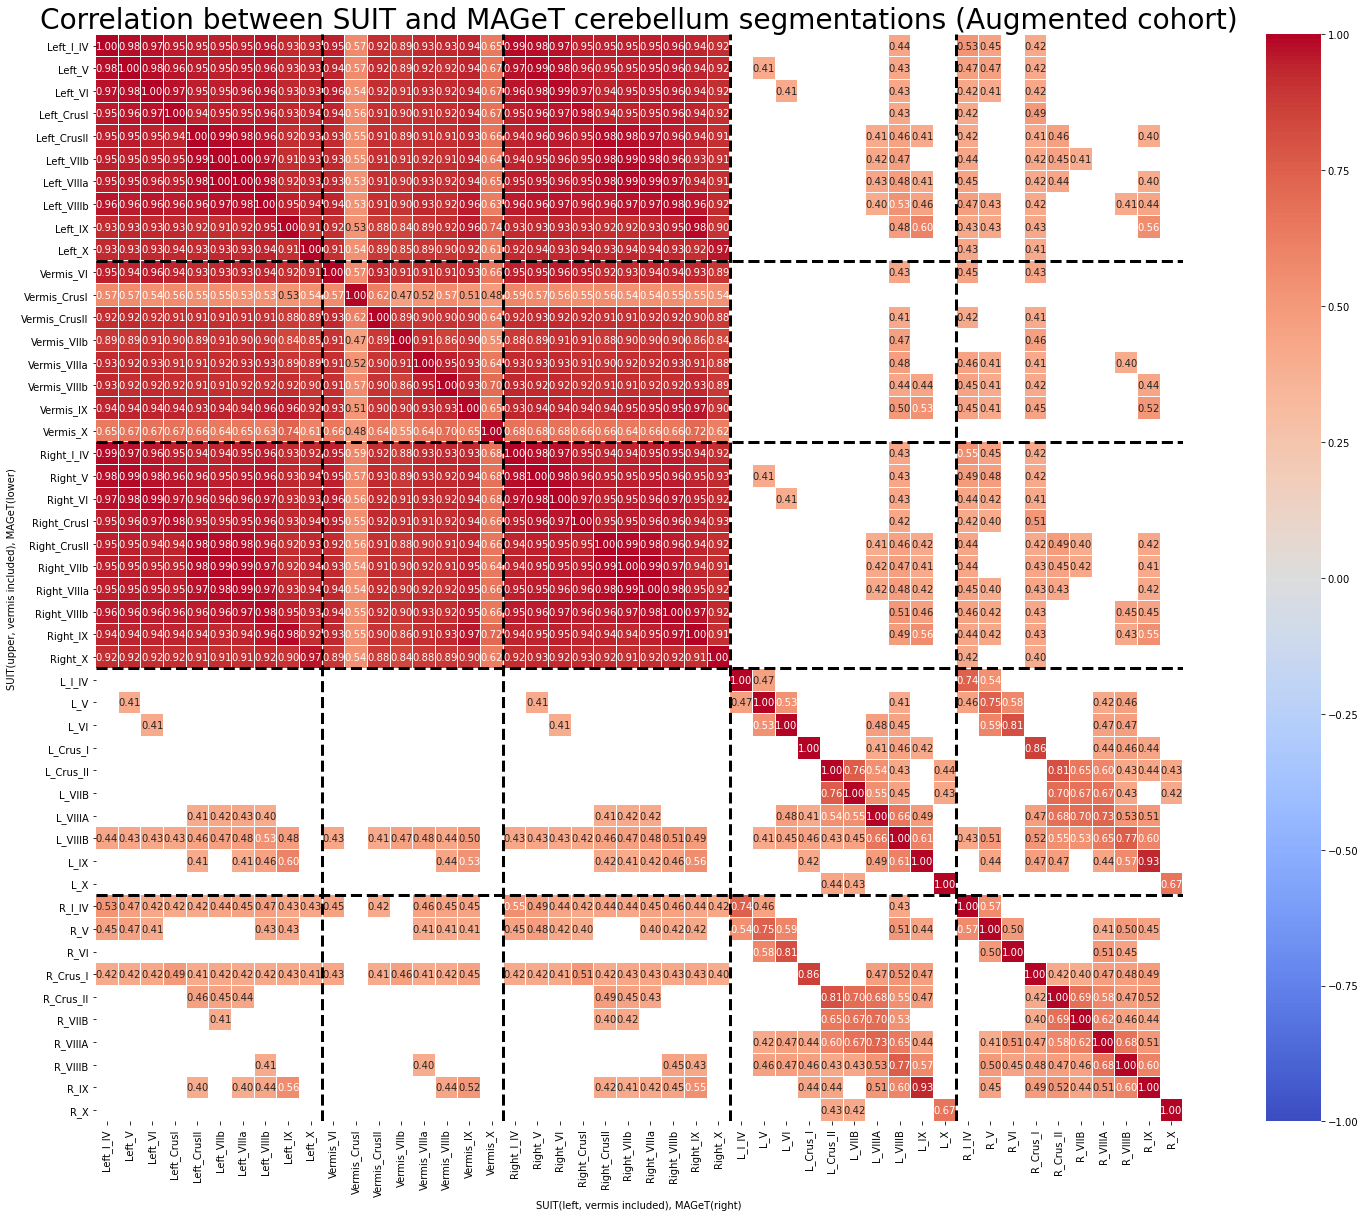

In [10]:
# Heatmap of correlation between SUIT and MAGeT measures (Augmented NC)
# vis config
C_MAP='coolwarm'; TH=0.4

# select data
vis_df=data_df.copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:end_lubule_list]+SUIT_v_labels+SUIT_r_labels[:end_lubule_list]+MAGeT_l_labels+MAGeT_r_labels]
# data proc
corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (Augmented cohort)', fontsize=28)
line_pos=[end_lubule_list,end_lubule_list+len(SUIT_v_labels),end_lubule_list*2+len(SUIT_v_labels),end_lubule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
#f1.savefig("Augmented-Cohort_SUIT-MAGeT_comp.jpg")
display(corr_)

(51, 54)


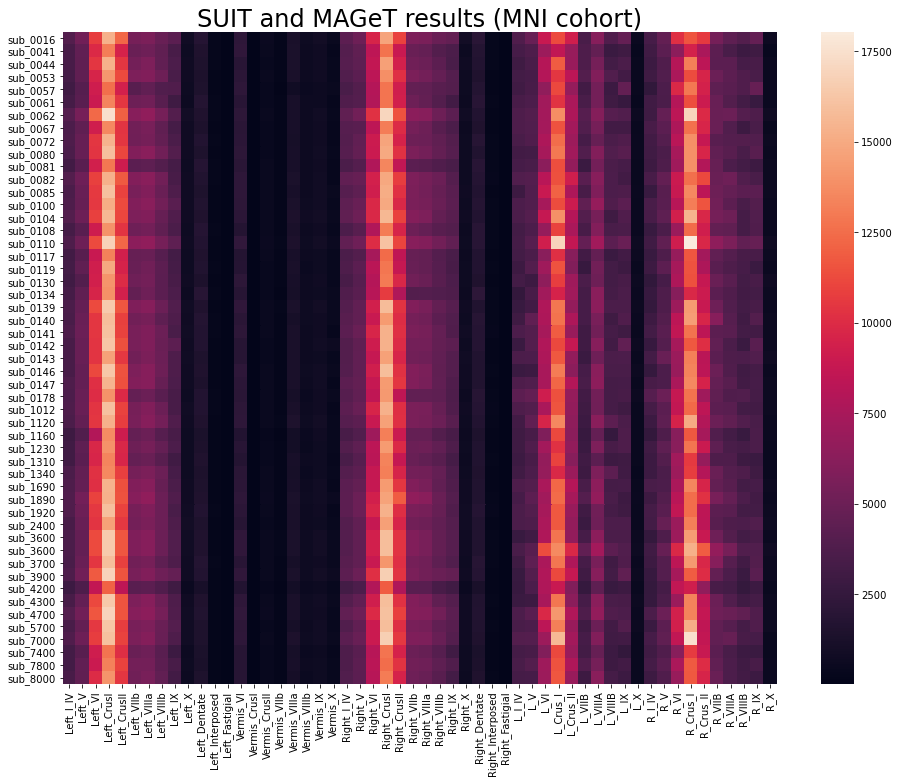

In [6]:
# visual inspection: Heatmap of SUIT and MAGeT measures
vis_df=data_df.loc[data_df['cohort']=='MNI'].copy()
vis_df=vis_df.loc[:,SUIT_l_labels+SUIT_v_labels+SUIT_r_labels+MAGeT_l_labels+MAGeT_r_labels]
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(vis_df, ax=ax)
ax.set_title('SUIT and MAGeT results (MNI cohort)', fontsize=24)
print(vis_df.shape)

(212, 54)


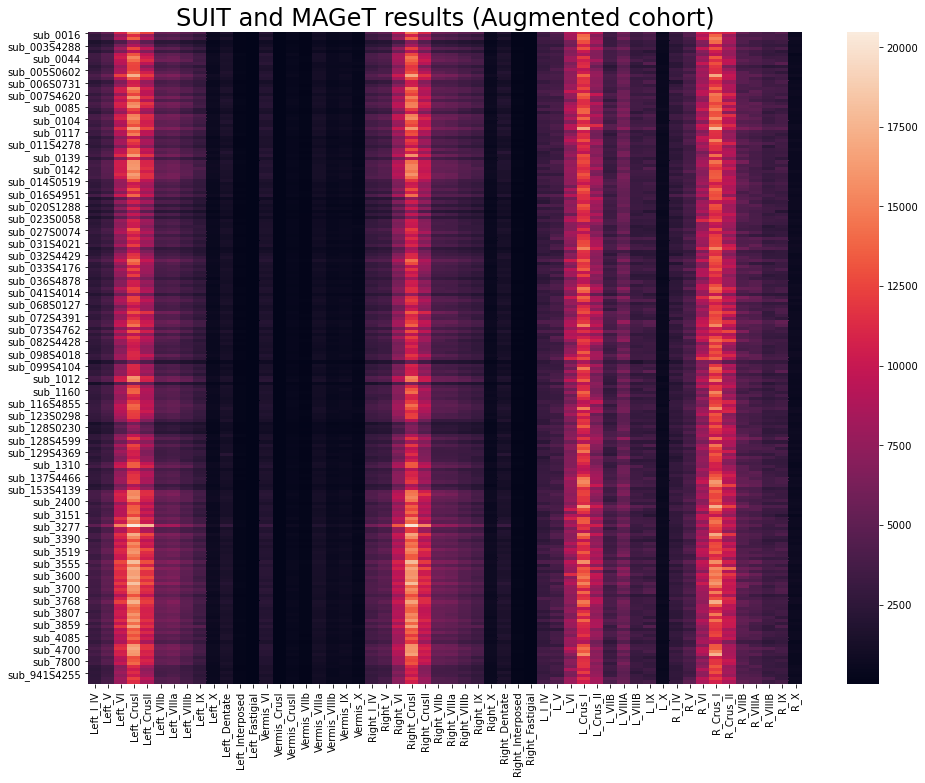

In [7]:
# Heatmap of results between SUIT and MAGeT measures (intercept)
vis_df=data_df.loc[:,SUIT_l_labels+SUIT_v_labels+SUIT_r_labels+MAGeT_l_labels+MAGeT_r_labels].copy()
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(vis_df, ax=ax)
ax.set_title('SUIT and MAGeT results (Augmented cohort)', fontsize=24)
print(vis_df.shape)

,Left_I_IV,Left_V,Left_VI,Left_CrusI,Left_CrusII,Left_VIIb,Left_VIIIa,Left_VIIIb,Left_IX,Left_X,...,R_I_IV,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X
Left_I_IV,1.000000,0.900347,0.776820,0.727401,0.803303,0.796219,0.793508,0.753667,0.520698,0.665550,...,0.484068,0.421128,0.536930,0.459404,0.426910,0.451270,0.729294,0.591719,0.381446,0.318826
Left_V,0.900347,1.000000,0.815019,0.757293,0.778080,0.727474,0.735916,0.739480,0.670197,0.653217,...,0.392650,0.512191,0.442543,0.420157,0.495222,0.470009,0.609699,0.517719,0.545566,0.424321
Left_VI,0.776820,0.815019,1.000000,0.850931,0.803665,0.782328,0.802041,0.842835,0.695237,0.656146,...,0.057083,0.318224,0.345530,0.526192,0.408031,0.538868,0.596983,0.436455,0.479928,0.419576
Left_CrusI,0.727401,0.757293,0.850931,1.000000,0.786153,0.805971,0.817036,0.788184,0.732952,0.719101,...,-0.002605,0.276952,0.377642,0.608530,0.428179,0.498363,0.561811,0.251270,0.540084,0.485663
Left_CrusII,0.803303,0.778080,0.803665,0.786153,1.000000,0.916539,0.872277,0.780884,0.644818,0.660539,...,0.148380,0.188743,0.356803,0.434528,0.656779,0.597557,0.589805,0.339588,0.524845,0.338573
Left_VIIb,0.796219,0.727474,0.782328,0.805971,0.916539,1.000000,0.980052,0.861680,0.553255,0.675417,...,0.148148,0.188677,0.303890,0.532799,0.543382,0.507971,0.648221,0.386459,0.382381,0.280547
Left_VIIIa,0.793508,0.735916,0.802041,0.817036,0.872277,0.980052,1.000000,0.912276,0.567031,0.667306,...,0.101355,0.224977,0.278595,0.517574,0.490652,0.467042,0.655323,0.422013,0.364187,0.275922
Left_VIIIb,0.753667,0.739480,0.842835,0.788184,0.780884,0.861680,0.912276,1.000000,0.625899,0.728178,...,0.073545,0.375020,0.280542,0.470108,0.338052,0.338504,0.567018,0.504378,0.444711,0.359841
Left_IX,0.520698,0.670197,0.695237,0.732952,0.644818,0.553255,0.567031,0.625899,1.000000,0.493615,...,-0.136301,0.287928,0.279345,0.375881,0.514061,0.384136,0.311953,0.189275,0.858017,0.511868
Left_X,0.665550,0.653217,0.656146,0.719101,0.660539,0.675417,0.667306,0.728178,0.493615,1.000000,...,0.267094,0.492735,0.358808,0.588383,0.187590,0.217288,0.483946,0.381203,0.484573,0.578022


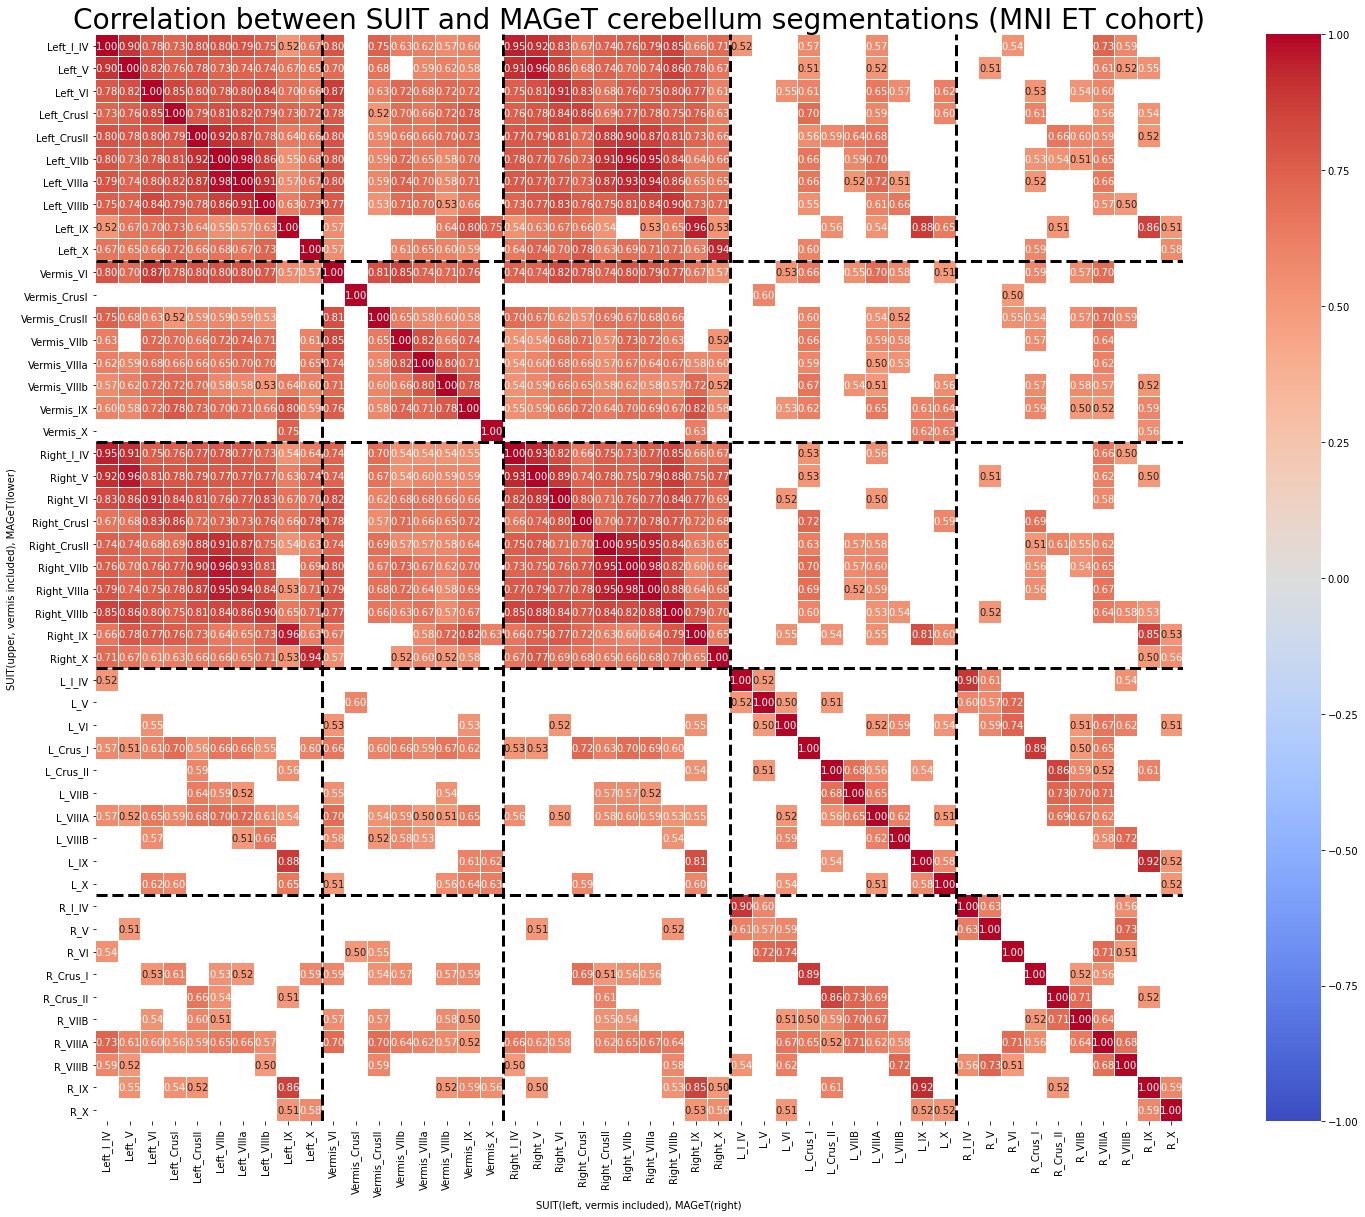

In [8]:
# Heatmap of correlation between SUIT and MAGeT measures (MNI ET)
C_MAP='coolwarm'; TH=0.5
vis_df=data_df.loc[(data_df['group']=='ET')].copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:end_lubule_list]+SUIT_v_labels+SUIT_r_labels[:end_lubule_list]+MAGeT_l_labels+MAGeT_r_labels]

corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')
#mask_=mask_.where(mask_==np.NaN, True)

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (MNI ET cohort)', fontsize=28)
line_pos=[end_lubule_list,end_lubule_list+len(SUIT_v_labels),end_lubule_list*2+len(SUIT_v_labels),end_lubule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
f1.savefig("MNI_ET_SUIT-MAGeT_comp.jpg")
display(corr_)

,Left_I_IV,Left_V,Left_VI,Left_CrusI,Left_CrusII,Left_VIIb,Left_VIIIa,Left_VIIIb,Left_IX,Left_X,...,R_I_IV,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X
Left_I_IV,1.000000,0.982330,0.972995,0.955220,0.944979,0.950030,0.953310,0.962599,0.933707,0.929279,...,0.496719,0.456202,0.284789,0.443432,0.434950,0.295201,0.339704,0.398943,0.411174,0.096998
Left_V,0.982330,1.000000,0.986923,0.964182,0.955207,0.955891,0.956823,0.962279,0.932466,0.938319,...,0.431871,0.468023,0.305972,0.441334,0.435225,0.312649,0.331412,0.415237,0.395416,0.120522
Left_VI,0.972995,0.986923,1.000000,0.970668,0.948428,0.953481,0.955970,0.961283,0.936796,0.939775,...,0.407615,0.416858,0.309675,0.440904,0.414419,0.297240,0.318295,0.408092,0.394992,0.112070
Left_CrusI,0.955220,0.964182,0.970668,1.000000,0.944832,0.950955,0.954014,0.955456,0.929740,0.938863,...,0.402621,0.396803,0.282875,0.517254,0.389338,0.282213,0.323283,0.415149,0.403786,0.116407
Left_CrusII,0.944979,0.955207,0.948428,0.944832,1.000000,0.988051,0.982195,0.963547,0.921713,0.932481,...,0.396267,0.392373,0.268009,0.426825,0.508490,0.398118,0.396591,0.419896,0.432624,0.130298
Left_VIIb,0.950030,0.955891,0.953481,0.950955,0.988051,1.000000,0.995286,0.975692,0.923059,0.939419,...,0.421968,0.392730,0.274460,0.431147,0.496301,0.409680,0.396588,0.416526,0.431069,0.111731
Left_VIIIa,0.953310,0.956823,0.955970,0.954014,0.982195,0.995286,1.000000,0.981419,0.932516,0.940758,...,0.434583,0.402236,0.276017,0.431149,0.490936,0.393317,0.403448,0.420713,0.441300,0.107936
Left_VIIIb,0.962599,0.962279,0.961283,0.955456,0.963547,0.975692,0.981419,1.000000,0.958438,0.941163,...,0.462992,0.434429,0.261093,0.435468,0.464178,0.352867,0.383114,0.458572,0.490168,0.077769
Left_IX,0.933707,0.932466,0.936796,0.929740,0.921713,0.923059,0.932516,0.958438,1.000000,0.919484,...,0.437049,0.435511,0.257658,0.451911,0.433823,0.298805,0.349521,0.463446,0.585427,0.111398
Left_X,0.929279,0.938319,0.939775,0.938863,0.932481,0.939419,0.940758,0.941163,0.919484,1.000000,...,0.398099,0.369828,0.267641,0.413138,0.409087,0.291605,0.289052,0.349006,0.399790,0.129627


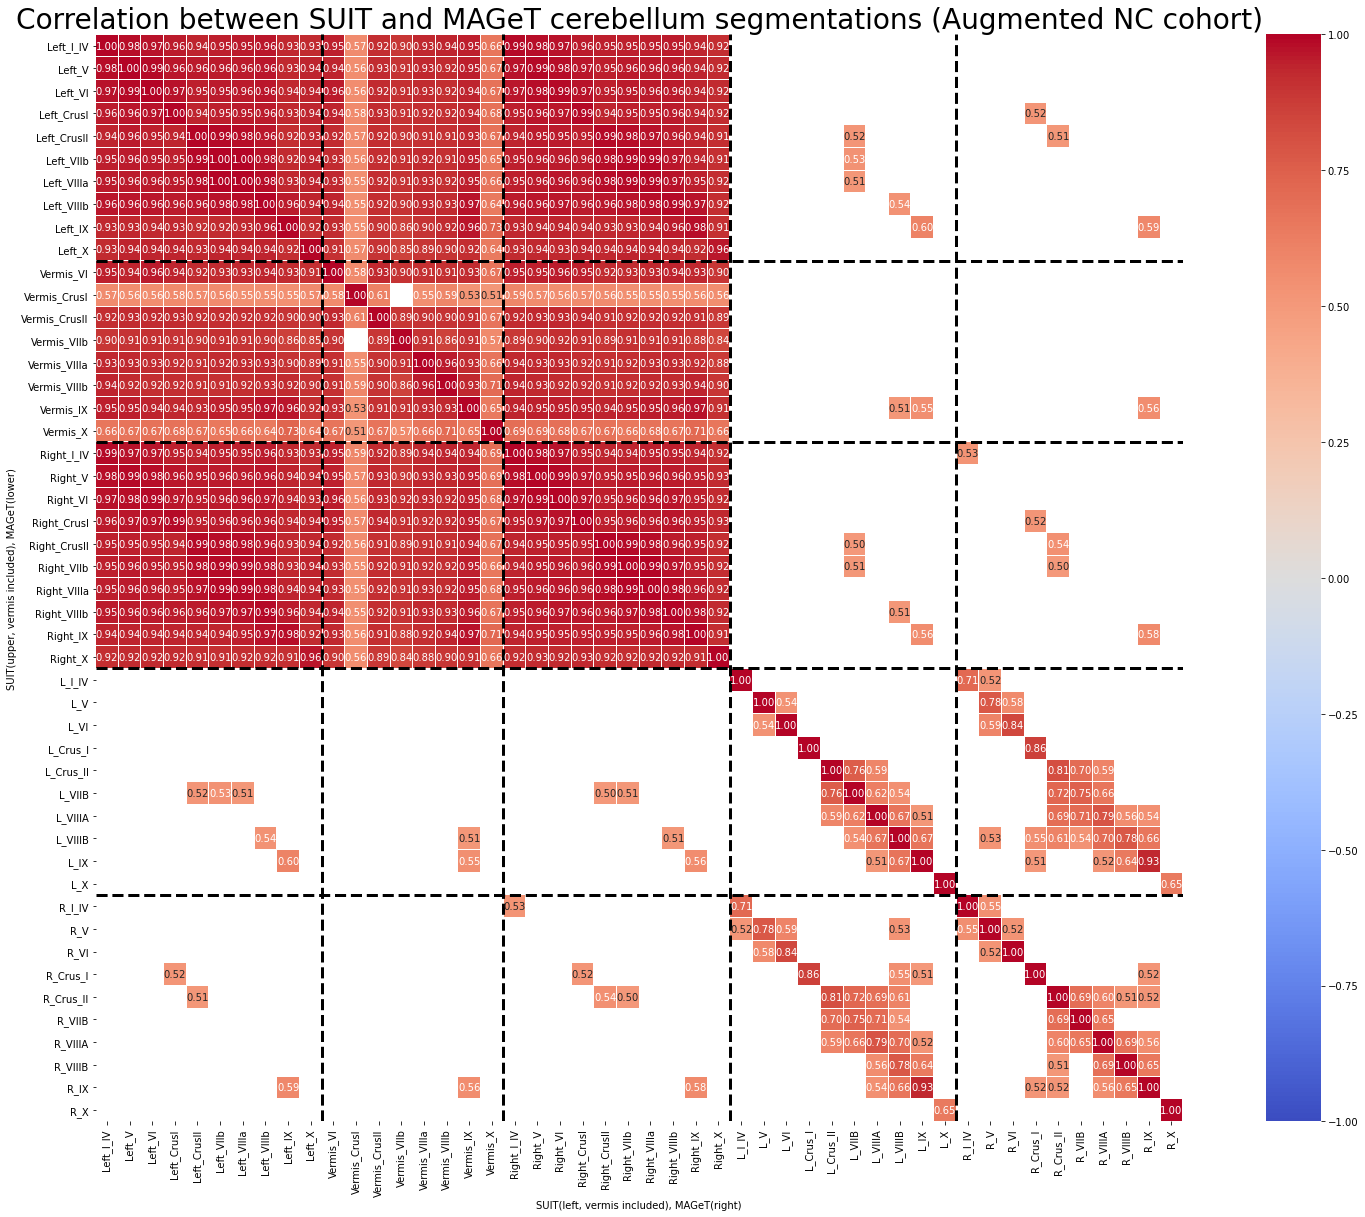

In [12]:
# Heatmap of correlation between SUIT and MAGeT measures (Augmented NC)
C_MAP='coolwarm'; TH=0.5
vis_df=data_df.loc[data_df['group']=='NC'].copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:end_lubule_list]+SUIT_v_labels+SUIT_r_labels[:end_lubule_list]+MAGeT_l_labels+MAGeT_r_labels]

corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')
#mask_=mask_.where(mask_==np.NaN, True)

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (Augmented NC cohort)', fontsize=28)
line_pos=[end_lubule_list,end_lubule_list+len(SUIT_v_labels),end_lubule_list*2+len(SUIT_v_labels),end_lubule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
f1.savefig("AUG_NC_SUIT-MAGeT_comp.jpg")
display(corr_)

,Left_I_IV,Left_V,Left_VI,Left_CrusI,Left_CrusII,Left_VIIb,Left_VIIIa,Left_VIIIb,Left_IX,Left_X,...,R_I_IV,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X
Left_I_IV,1.000000,0.982452,0.970506,0.953836,0.947013,0.948965,0.952291,0.961004,0.925529,0.927165,...,0.526292,0.448895,0.216491,0.419046,0.375707,0.299882,0.257166,0.365614,0.367536,-0.025335
Left_V,0.982452,1.000000,0.983181,0.961845,0.954851,0.951845,0.953389,0.960080,0.930211,0.933815,...,0.467451,0.465564,0.230003,0.415937,0.381757,0.316459,0.246257,0.376609,0.365613,0.002627
Left_VI,0.970506,0.983181,1.000000,0.969993,0.949950,0.951935,0.955183,0.962444,0.934460,0.934712,...,0.424740,0.410979,0.229750,0.424997,0.361650,0.310761,0.238754,0.367949,0.363728,0.000137
Left_CrusI,0.953836,0.961845,0.969993,1.000000,0.944988,0.948843,0.952873,0.955616,0.930424,0.937021,...,0.417422,0.390458,0.204797,0.493076,0.336786,0.296900,0.234791,0.356934,0.372307,0.000314
Left_CrusII,0.947013,0.954851,0.949950,0.944988,1.000000,0.986585,0.980025,0.961139,0.918947,0.927759,...,0.419338,0.382458,0.201495,0.409052,0.462847,0.399737,0.311845,0.375674,0.402610,0.018671
Left_VIIb,0.948965,0.951845,0.951935,0.948843,0.986585,1.000000,0.995063,0.972644,0.914358,0.932507,...,0.438363,0.383232,0.208713,0.423254,0.451157,0.405765,0.323556,0.379908,0.396207,0.007986
Left_VIIIa,0.952291,0.953389,0.955183,0.952873,0.980025,0.995063,1.000000,0.980083,0.923356,0.934056,...,0.446430,0.393615,0.205350,0.421699,0.440577,0.388805,0.326636,0.384302,0.401925,0.000289
Left_VIIIb,0.961004,0.960080,0.962444,0.955616,0.961139,0.972644,0.980083,1.000000,0.949083,0.939224,...,0.471364,0.429436,0.182492,0.416028,0.397531,0.340958,0.288700,0.413778,0.440860,-0.034535
Left_IX,0.925529,0.930211,0.934460,0.930424,0.918947,0.914358,0.923356,0.949083,1.000000,0.908027,...,0.429610,0.425328,0.184519,0.425915,0.388044,0.304610,0.249243,0.397439,0.558130,0.011445
Left_X,0.927165,0.933815,0.934712,0.937021,0.927759,0.932507,0.934056,0.939224,0.908027,1.000000,...,0.432483,0.388536,0.198483,0.412579,0.341025,0.282504,0.210270,0.316232,0.371119,0.029298


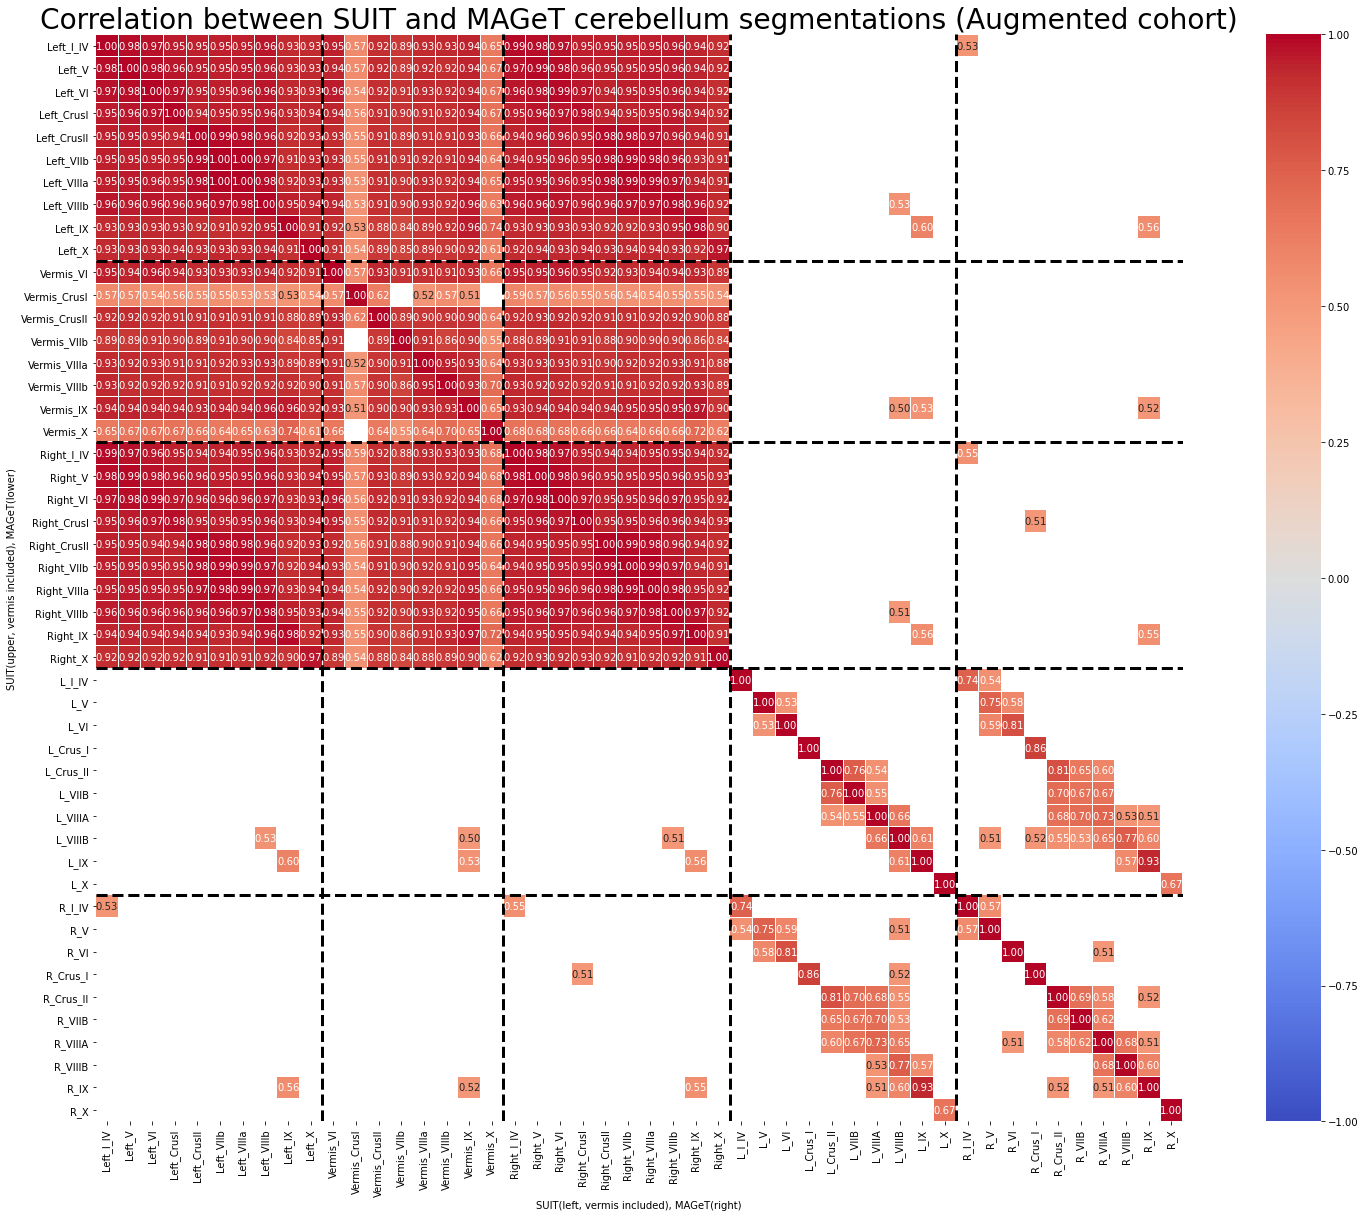

In [16]:
#GLM for the augmented group
tmp_df=data_df.copy()

tar_list_suit = ['Left_CrusI', 'Left_CrusII', 'Right_CrusI','Right_CrusII']
tar_list_maget = ['L_Crus_I', 'L_Crus_II', 'R_Crus_I', 'R_Crus_II']

covariate_model_all_str = '~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))';
# Test for SUIT results
covariate_dict_suit_all = glm_test(tmp_df, tar_list_suit, covariate_model_all_str);
# Test for MAGeT results:
covariate_dict_maget_all = glm_test(tmp_df, tar_list_maget, covariate_model_all_str);

#Reporting results
alpha_=0.05
print('SUIT @MNI Cohort (Significant):')
rep_model(covariate_dict_suit_all, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_})
print('MAGeT @Augmented Cohort (Significant):')
rep_model(covariate_dict_maget_all, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_})


SUIT @MNI Cohort (Significant):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :

MAGeT @Augmented Cohort (Significant):
Only display significant results @ 0.05  for  C(group, Treatment(reference="NC"))[T.ET]  :



{'L_Crus_I': {'formula': 'L_Crus_I~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f3a4a4d2190>},
 'L_Crus_II': {'formula': 'L_Crus_II~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f3a4a4c7880>},
 'R_Crus_I': {'formula': 'R_Crus_I~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f3a5153f910>},
 'R_Crus_II': {'formula': 'R_Crus_II~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC"))',
  'res': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x7f3a4a4c76a0>}}

In [17]:
print('SUIT @MNI Cohort (all):')
rep_model(covariate_dict_suit_all, {'name':'all'});
print('MAGeT @Augmented Cohort (all):')
rep_model(covariate_dict_maget_all, {'name':'all'});

SUIT @MNI Cohort (all):
Display all results:



Left_CrusI~age+C(sex, Treatment(reference="F"))+eTIV+C(cohort, Treatment(reference="MNI"))+C(group, Treatment(reference="NC")) 

                                   Results: Generalized linear model
Model:                          GLM                          AIC:                        3725.6964     
Link Function:                  identity                     BIC:                        498298031.6854
Dependent Variable:             Left_CrusI                   Log-Likelihood:             -1855.8       
Date:                           2021-12-17 01:09             LL-Null:                    -2062.5       
No. Observations:               212                          Deviance:                   4.9830e+08    
Df Model:                       6                            Pearson chi2:               4.98e+08      
Df Residuals:                   205                          Scale:                      2.4307e+06    
Method:                   

In [ ]:
# GLM analysis for MNI cohort
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from utils_et_biomarker.utils import glm_test, rep_model

alpha_=0.05

tmp_df=data_df.loc[(data_df['group']=='ET') | (data_df['group']=='NC')].copy()
tar_list_suit = ['Left_CrusI', 'Left_CrusII', 'Right_CrusI','Right_CrusII']
tar_list_maget = ['L_Crus_I', 'L_Crus_II', 'R_Crus_I', 'R_Crus_II']

# Using eTIV as covariate before QC
covariate_model_str  = '~age+C(sex, Treatment(reference="F") )+eTIV+C(group, Treatment(reference="NC"))';
covariate_dict_suit  = glm_test(tmp_df, tar_list_suit, covariate_model_str);
covariate_dict_maget = glm_test(tmp_df, tar_list_maget, covariate_model_str);

#Reporting results
alpha_=0.05
print('SUIT @MNI Cohort (significant):')
rep_model(covariate_dict_suit, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_})
print('MAGeT @Augmented Cohort (significant):')
rep_model(covariate_dict_maget, {'name':'significant','col_name':'C(group, Treatment(reference="NC"))[T.ET]','th':alpha_})
print('SUIT @MNI Cohort (all):')
rep_model(covariate_dict_suit, {'name':'all'});
print('MAGeT @Augmented Cohort (all):')
rep_model(covariate_dict_maget, {'name':'all'});

,Left_I_IV,Left_V,Left_VI,Left_CrusI,Left_CrusII,Left_VIIb,Left_VIIIa,Left_VIIIb,Left_IX,Left_X,...,R_I_IV,R_V,R_VI,R_Crus_I,R_Crus_II,R_VIIB,R_VIIIA,R_VIIIB,R_IX,R_X
Left_I_IV,1.000000,0.979999,0.972592,0.950883,0.945002,0.949240,0.952328,0.961195,0.932834,0.931366,...,0.508935,0.481226,0.336139,0.463396,0.465097,0.359292,0.364029,0.417935,0.437210,0.120354
Left_V,0.979999,1.000000,0.987606,0.959533,0.952338,0.953343,0.954625,0.962520,0.932861,0.941107,...,0.455929,0.497376,0.356676,0.461607,0.460299,0.362985,0.342096,0.427925,0.429980,0.143190
Left_VI,0.972592,0.987606,1.000000,0.967366,0.949137,0.953754,0.956125,0.962193,0.936033,0.942197,...,0.426187,0.447698,0.358383,0.461386,0.441205,0.351778,0.328771,0.413460,0.422315,0.126883
Left_CrusI,0.950883,0.959533,0.967366,1.000000,0.945100,0.949135,0.952004,0.953981,0.926157,0.938785,...,0.400066,0.411856,0.335127,0.536568,0.422524,0.334571,0.329142,0.414014,0.422129,0.128856
Left_CrusII,0.945002,0.952338,0.949137,0.945100,1.000000,0.989088,0.983939,0.965426,0.923468,0.938050,...,0.396760,0.408738,0.313914,0.426560,0.541140,0.444254,0.401215,0.421269,0.448901,0.139930
Left_VIIb,0.949240,0.953343,0.953754,0.949135,0.989088,1.000000,0.995472,0.976075,0.923370,0.944257,...,0.418409,0.411146,0.319651,0.423926,0.525702,0.450683,0.395452,0.412306,0.440681,0.117341
Left_VIIIa,0.952328,0.954625,0.956125,0.952004,0.983939,0.995472,1.000000,0.981915,0.932670,0.945232,...,0.427010,0.419643,0.321120,0.427685,0.519519,0.433764,0.400600,0.418873,0.450792,0.118584
Left_VIIIb,0.961195,0.962520,0.962193,0.953981,0.965426,0.976075,0.981915,1.000000,0.959659,0.947811,...,0.458450,0.455779,0.309738,0.444694,0.487460,0.396474,0.383218,0.463373,0.504532,0.103814
Left_IX,0.932834,0.932861,0.936033,0.926157,0.923468,0.923370,0.932670,0.959659,1.000000,0.926219,...,0.435243,0.452903,0.298167,0.465839,0.461573,0.348116,0.361048,0.474217,0.606728,0.131975
Left_X,0.931366,0.941107,0.942197,0.938785,0.938050,0.944257,0.945232,0.947811,0.926219,1.000000,...,0.400682,0.395976,0.312915,0.429321,0.444270,0.340326,0.303948,0.365556,0.431320,0.140382


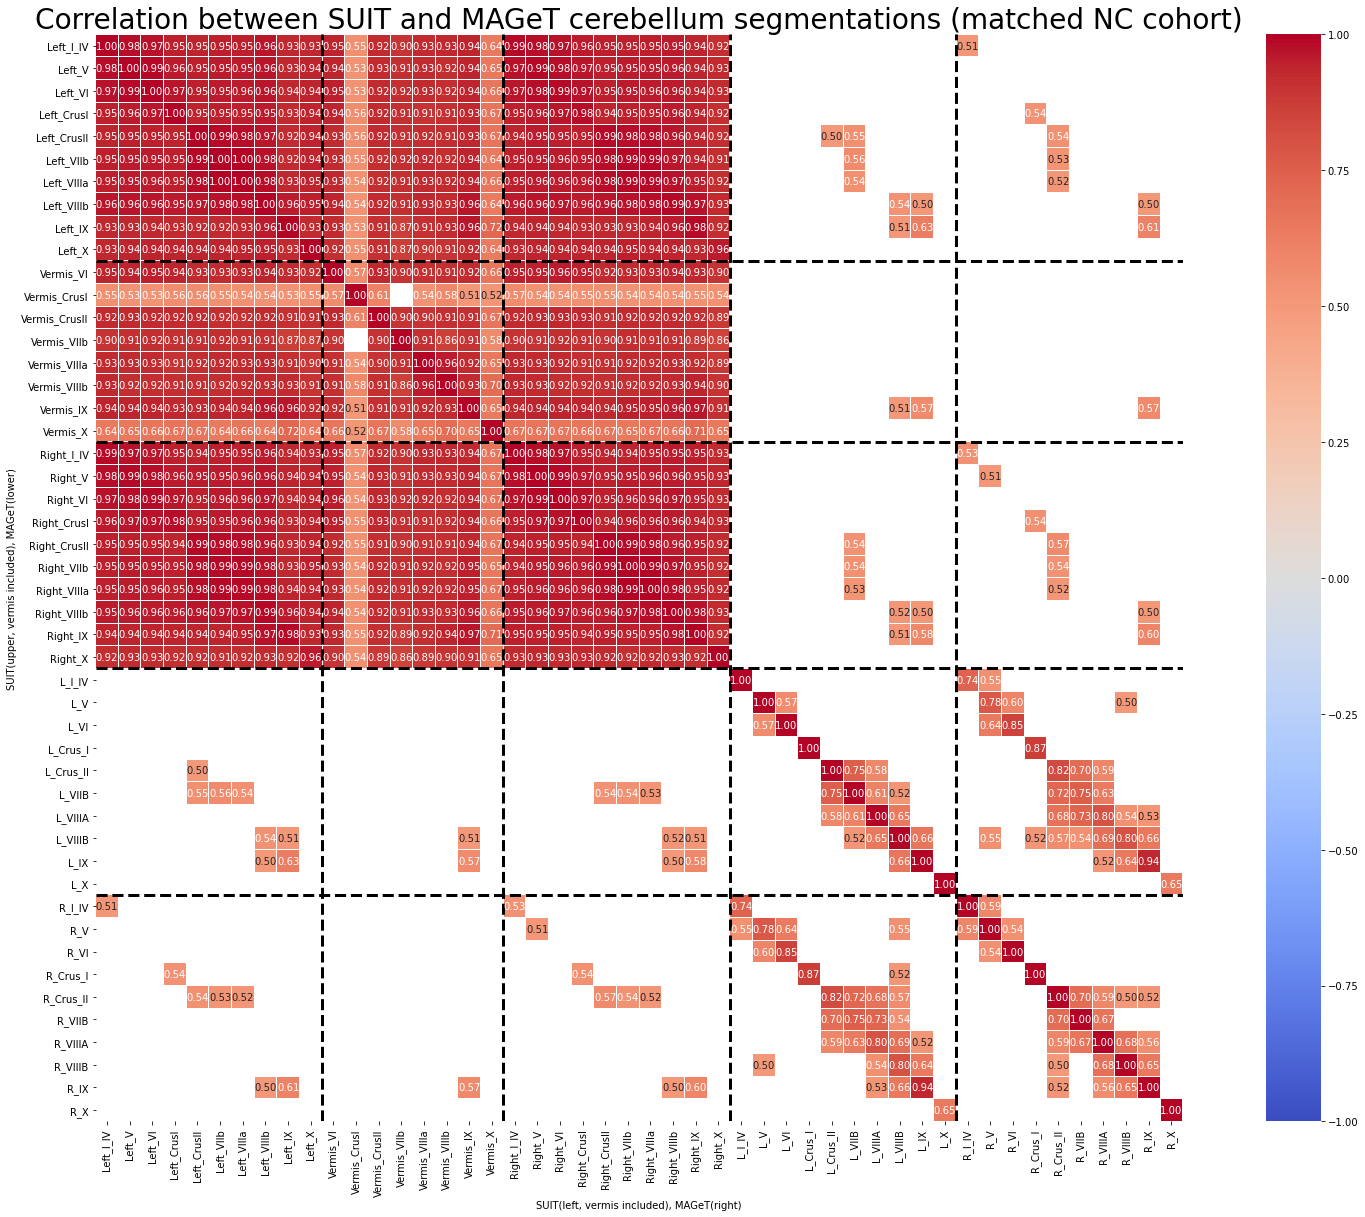

In [14]:
# results from the matched cohort
matched_data_file = data_dir/'matched_Des-cere_qced.csv'
matched_df = pd.read_csv(matched_data_file , sep=',', header=0, index_col=0);
matched_df=matched_df.join(maget_df, how='left')

# Heatmap of correlation between SUIT and MAGeT measures (Augmented NC)
C_MAP='coolwarm'; TH=0.5
vis_df=matched_df.loc[matched_df['group']=='NC'].copy()
vis_df=vis_df.loc[:,SUIT_l_labels[:end_lubule_list]+SUIT_v_labels+SUIT_r_labels[:end_lubule_list]+MAGeT_l_labels+MAGeT_r_labels]

corr_=vis_df.corr()
mask_=corr_.where(np.abs(corr_)>TH, True).copy()
mask_=mask_.applymap(lambda x: False if isinstance(x, float) else True, na_action='ignore')
#mask_=mask_.where(mask_==np.NaN, True)

# Draw a heatmap with the numeric values in each cell
f1, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr_, ax=ax, annot=True, fmt=".2f", mask=mask_,
            vmax=1, vmin=-1, cmap=C_MAP, square=True, linewidths=.05)
ax.set_ylabel("SUIT(upper, vermis included), MAGeT(lower)")
ax.set_xlabel("SUIT(left, vermis included), MAGeT(right)")
ax.set_title('Correlation between SUIT and MAGeT cerebellum segmentations (matched NC cohort)', fontsize=28)
line_pos=[end_lubule_list,end_lubule_list+len(SUIT_v_labels),end_lubule_list*2+len(SUIT_v_labels),end_lubule_list*3+len(SUIT_v_labels)]
for x in line_pos:
    plt.axhline(x, ls='--',c='k', lw=3); plt.axvline(x, ls='--',c='k', lw=3)
f1.savefig("matched_NC-MAGeT_comp.jpg")
display(corr_)